In [112]:
import numpy as np
import matplotlib.pyplot as plt

### Aufgabe 5.1 & 5.2

In [113]:
def parameterized_spline(xj_1, xj, yj_1, yj, hj, Mj_1, Mj):
    cj = yj_1 - 1/6 * Mj_1 * hj**2
    dj = yj - 1/6 * Mj * hj**2
    return lambda x: Mj_1 * (xj - x)**3 / (6*hj) + Mj * (x - xj_1)**3 / (6*hj) + cj * (xj - x)/hj + dj * (x - xj_1)/hj

def get_natural_cubic_spline_matrix(h: np.array):
    size = len(h) - 1
    a_diag = np.zeros((size, size), float)
    h_diag = (h[:-1] + h[1:])/3
    np.fill_diagonal(a_diag, h_diag)
    
    a_diag_low = np.zeros((size - 1, size - 1), float)
    a_diag_up = np.zeros((size - 1, size - 1), float)
    h_low = h[1:-1]/6
    np.fill_diagonal(a_diag_low, h_low)
    np.fill_diagonal(a_diag_up, h_low)
    a_diag_low = np.pad(a_diag_low, [(1, 0), (0, 1)], mode='constant')
    a_diag_up = np.pad(a_diag_up, [(0, 1), (1, 0)], mode='constant')
    
    return a_diag + a_diag_low + a_diag_up

def get_hermite_cubic_spline_matrix(h: np.array):
    natural = get_natural_cubic_spline_matrix(h)
    hermite = np.pad(natural, 1, mode='constant')
    shape = hermite.shape
    hermite[0, 0] = h[0]/3
    hermite[0, 1] = h[0]/6
    hermite[1, 0] = h[0]/6
    hermite[shape[0]-1, shape[1]-1] = h[len(h)-1] / 3
    hermite[shape[0]-1, shape[1]-2] = h[len(h)-1] / 6
    hermite[shape[0]-2, shape[1]-1] = h[len(h)-1] / 6
    return hermite

In [114]:
def cubicSpline(x, y, xx, yPrime=None):
    h = np.diff(x)
    y_diff = np.diff(y)
    k = y_diff / h
    b = np.diff(k)
    
    if yPrime is not None:
        a = get_hermite_cubic_spline_matrix(h)
        b = np.concatenate(([k[0] - yPrime[0]], b))
        b = np.concatenate((b, [yPrime[1] - k[len(k)-1]]))
        M = np.linalg.solve(a, b)
    else:
        a = get_natural_cubic_spline_matrix(h)
        M = np.linalg.solve(a, b)
        M = np.concatenate((M, [0]))
        M = np.concatenate(([0], M))
        
    splines = []
    for i in range(1, len(x)):
        s = parameterized_spline(x[i-1], x[i], y[i-1], y[i], h[i-1], M[i-1], M[i])
        splines.append(s)

    def cal_yy(x, splines, xi):
        for i in range(len(x) - 1):
            if xi >= x[i] and xi <= x[i+1]:
                return splines[i](xi)
        print(f"{xi} is outside of the Definitionsbereich")
        return None
    
    yy = np.array([])
    for xi in xx:
        yy = np.append(yy, cal_yy(x, splines, xi))
    return yy
        

In [115]:
def cubicNaturalSpline(x, y, xx):
    return cubicSpline(x, y, xx)

def cubicHermiteSpline(x,y,yPrime,xx):
    return cubicSpline(x, y, xx, yPrime)

### Aufgabe 5.3

In [116]:
x_a = np.array([-1, -1/2, -1/4, 0, 3/4, 1])
y_a = np.array([0.6667, 0.2083, -0.3177, -1, -3.6719, -4.6667])
y_a_prime = [0, -4]

x_b = np.array([-1, -1/2, -1/4, 0, 3/4, 1])
y_b = np.array([-1.25, -1, -0.5007, 0, 1.5989, 2.75])
y_b_prime = [-3, 7]

### 5.3 a)

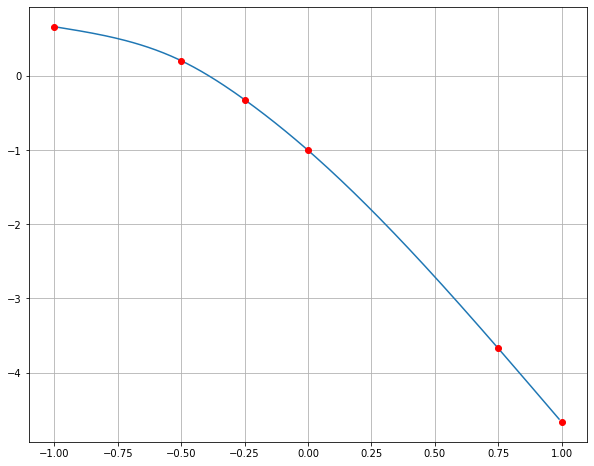

In [117]:
ax = np.arange(-1, 1, 0.01)
ay = cubicNaturalSpline(x_a, y_a, ax)
plt.figure(figsize = (10,8))
plt.grid()
plt.plot(ax, ay)
plt.plot(x_a, y_a, 'ro')

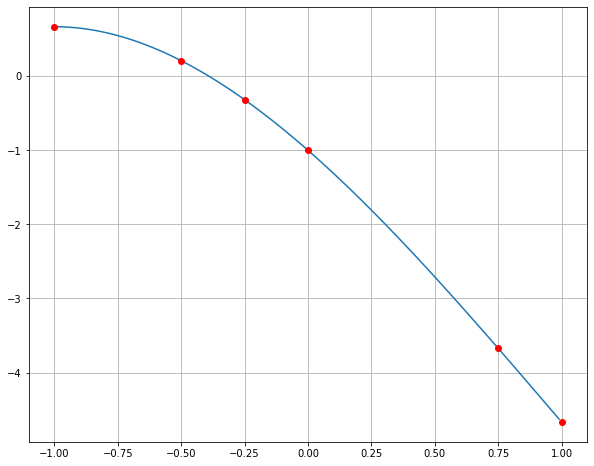

In [118]:
ay = cubicHermiteSpline(x_a, y_a, y_a_prime, ax)
plt.figure(figsize = (10,8))
plt.grid()
plt.plot(ax, ay)
plt.plot(x_a, y_a, 'ro')

### 5.3 b)

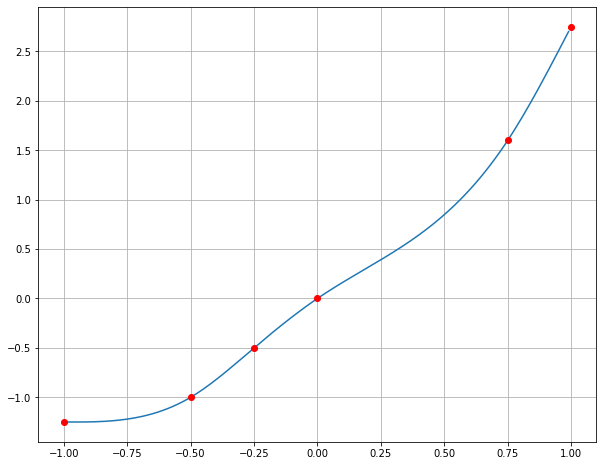

In [119]:
ax = np.arange(-1, 1, 0.01)
ay = cubicNaturalSpline(x_b, y_b, ax)
plt.figure(figsize = (10,8))
plt.grid()
plt.plot(ax, ay)
plt.plot(x_b, y_b, 'ro')

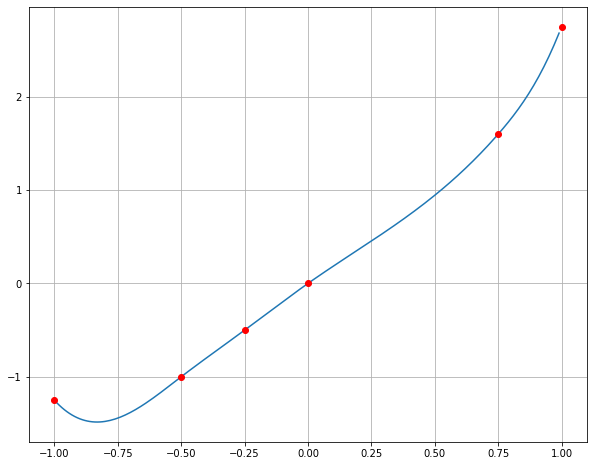

In [120]:
ay = cubicHermiteSpline(x_b, y_b, y_b_prime, ax)
plt.figure(figsize = (10,8))
plt.grid()
plt.plot(ax, ay)
plt.plot(x_b, y_b, 'ro')

### Aufgabe 5.4 & 5.5

In [121]:
def cubicSplineCurve(y,k,yPrime=None):
    x1 = np.array(list(zip(*y))[0])
    x2 = np.array(list(zip(*y))[1])
    x1_diff = np.diff(x1)
    x2_diff = np.diff(x2)

    t = [0]
    for i in range(1, len(y)):
        tk = t[i-1] + np.sqrt(x1_diff[i-1]**2 + x2_diff[i-1]**2)
        t.append(tk)

    t_max = t[len(t)-1]
    t_min = t[0]
    interval = (t_max - t_min)/k
    at = np.arange(t_min, t_max + interval, interval)

    if yPrime is None:
        ax1 = cubicNaturalSpline(t, x1, at)
        ax2 = cubicNaturalSpline(t, x2, at)
    else:
        x1_prime = np.array(list(zip(*yPrime))[0])
        x2_prime = np.array(list(zip(*yPrime))[1])
        ax1 = cubicHermiteSpline(t, x1, x1_prime, at)
        ax2 = cubicHermiteSpline(t, x2, x2_prime, at)  
    return (ax1, ax2)

In [122]:
def cubicNaturalSplineCurve(y,k):
    return cubicSplineCurve(y,k)

def cubicHermiteSplineCurve(y,yPrime,k):
    return cubicSplineCurve(y,k, yPrime)

### Aufgabe 5.6

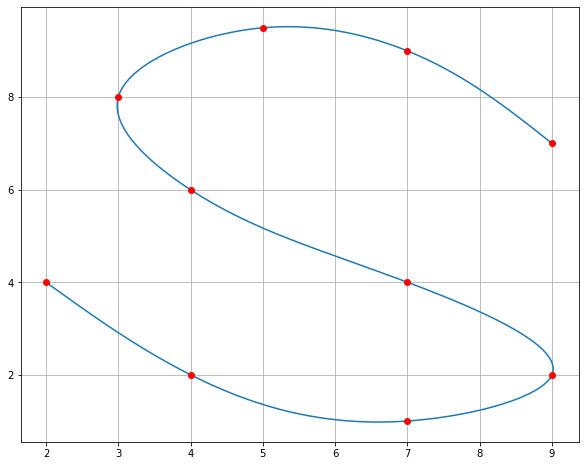

In [123]:
s_letter = [(2,4),(4,2),(7,1),(9,2),(7,4),(4,6),(3,8),(5,9.5),(7,9),(9,7)]

ax1, ax2 = cubicNaturalSplineCurve(s_letter, 200)
plt.figure(figsize = (10,8))
plt.grid()
plt.plot(ax1, ax2)

x1 = np.array(list(zip(*s_letter))[0])
x2 = np.array(list(zip(*s_letter))[1])
plt.plot(x1, x2, 'ro')

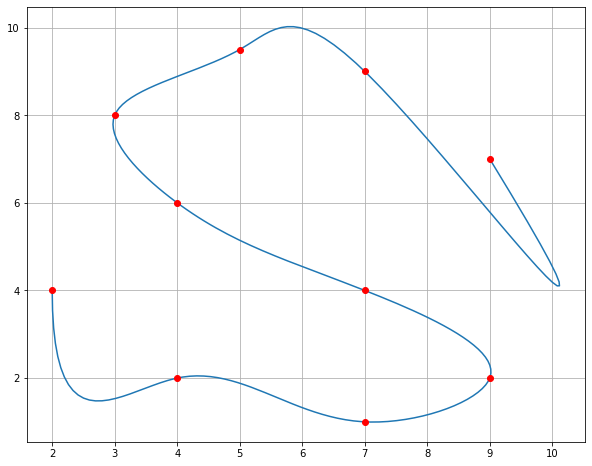

In [124]:
s_letter_prime = [(0, -4), (-3, 7)]
ax1, ax2 = cubicHermiteSplineCurve(s_letter, s_letter_prime, 200)
plt.figure(figsize = (10,8))
plt.grid()
plt.plot(ax1, ax2)
plt.plot(x1, x2, 'ro')

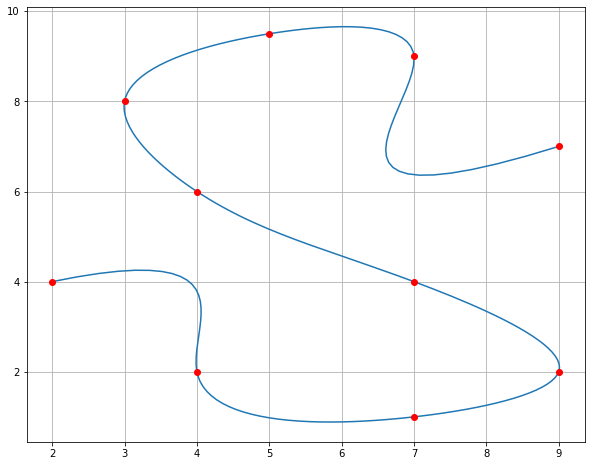

In [125]:
s_letter_prime = [(3, 1), (4, 2)]
ax1, ax2 = cubicHermiteSplineCurve(s_letter, s_letter_prime, 200)
plt.figure(figsize = (10,8))
plt.grid()
plt.plot(ax1, ax2)
plt.plot(x1, x2, 'ro')

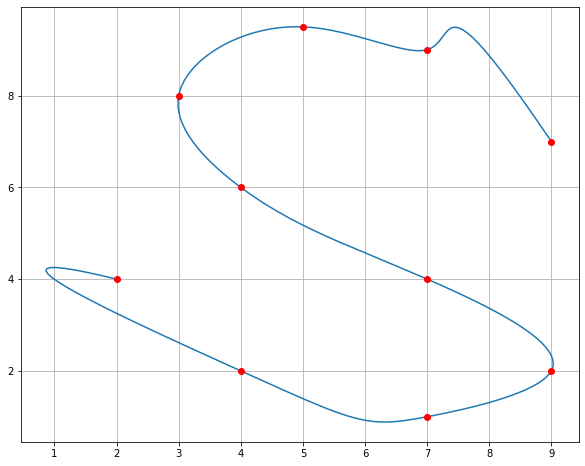

In [126]:
s_letter_prime = [(-3, 1), (2, -4)]
ax1, ax2 = cubicHermiteSplineCurve(s_letter, s_letter_prime, 200)
plt.figure(figsize = (10,8))
plt.grid()
plt.plot(ax1, ax2)
plt.plot(x1, x2, 'ro')